In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sts
from celluloid import Camera
from IPython.display import HTML
import jax.numpy as jnp
import jax.scipy as jsc
from jax.nn import softmax
plt.rc('figure', figsize=(10.0, 3.0), dpi=120, facecolor="w")
np.random.seed(222)

def kde(x, data, h):
    return jnp.mean(jsc.stats.norm.pdf(x.reshape(-1,1),loc=data,scale=h), axis=1)

def kde_hist(events, bins, bandwidth=None, density=False):
      """
      Args:
              events: (jax array-like) data to filter.

              bins: (jax array-like) intervals to calculate counts.

              bandwidth: (float) value that specifies the width of the individual
              distributions (kernels) whose cdfs are averaged over each bin. Defaults
              to Scott's rule -- the same as the scipy implementation of kde.

              density: (bool) whether or not to normalize the histogram to unit area.
      Returns:
              binned counts, calculated by kde!
      """
      bandwidth = bandwidth or events.shape[-1]**-.25 # Scott's rule

      edge_hi = bins[1:] # ending bin edges ||<-
      edge_lo = bins[:-1] # starting bin edges ->||

      # get cumulative counts (area under kde) for each set of bin edges
      cdf_up = jsc.stats.norm.cdf(edge_hi.reshape(-1,1),loc = events, scale = bandwidth)
      cdf_dn = jsc.stats.norm.cdf(edge_lo.reshape(-1,1),loc = events, scale = bandwidth)
      # sum kde contributions in each bin
      counts = (cdf_up - cdf_dn).sum(axis=1) 

      if density: # normalize by bin width and counts for total area = 1
            db = jnp.array(jnp.diff(bins), float) # bin spacing
            return counts/db/counts.sum(axis=0)

      return counts

In [ ]:
# This presentation is a Jupyter notebook! (thanks to https://github.com/damianavila/RISE )
2*2

4

# Physics analysis as a differentiable program
**Nathan Simpson** 

(supervised by & in collaboration with **Lukas Heinrich**)

<figure style="display:flex; padding-right: 20px; padding left: 20px;">
    <img src="assets/cern.jpg" width="140" />
    <img src="assets/lu.png" width="140" /> 
    <img src="assets/gradhep.png" width="140" />
    <img src="assets/insights.jpg" width="210" /> 
    <img src="assets/eu.png" width="210" />  
<figure/>

# We three things of presentation are:

- <span style="color:blue">**What does it mean for analysis to be 'differentiable'?**</span>
    - <span style="color:blue">*Why even care?*</span>

- <span style="color:purple">**How can we differentiate physics?**</span>
    - <span style="color:purple">feat. smoothing, pyhf, autodiff</span>

- <span style="color:teal">**Seeing it in action: *neos***</span>
    - <span style="color:teal">**m a c h i n e l e a r n i n g**!!!!! omg!!!!!!!</span>

<img src="assets/anaflow.png" width="70%"/>

**A typical analysis:** 

<span style="color:blue">data</span>  →      <span style="color:maroon">cutflow</span> → <span style="color:green">observable</span> → <span style="color:lightblue">model</span> → <span style="color:teal">test statistic</span> → <span style="color:orange">hypothesis test</span> → <span style="color:darkyellow">*limits* (p-values)</span>

<img src="assets/free.png" width="70%"/>

<span style="color:orange">**Free parameters:**</span> cut values, parameters of a multivariate observable

*Can we optimize them?*

**Sure we can!** 

Here's what we might do:

- *Cuts:*  grid search of <span style="color:orange">cut positions</span>
    - Objective: <span style="color:blue">maximize approximate median significance $Z_{A}^{\left(\sigma_{b}=0\right)}=\sqrt{2((s+b) \ln (1+s / b)-s)}$</span>
    
    

- *Observable (e.g. neural network):* train parameters <span style="color:orange">$\phi$</span> via gradient descent
    - Objective: <span style="color:blue">minimize binary cross entropy (signal vs background)</span>

Why do the methods and objectives differ if they're in the same pipeline?

**They don't have to!**

- *Sigmoid* cut optimized wrt $Z_A$ using gradient descent: ([notebook from Alex Held](https://mybinder.org/v2/gh/alexander-held/differentiable-analysis-example/master?filepath=Significance_optimization.ipynb))
    - Green curve is the cut profile, centered around the grey dotted line

<figure style="display:flex">
     <img src="assets/cc.png" width="40%"/>
    <img src="assets/cut.gif" width="40%"/>
</figure>

- Using $1/Z_A$ as a loss function: https://arxiv.org/abs/1806.00322

One could then imagine a *jointly-optimized pipeline* with respect to a single objective, trained using <span style="color:purple">gradient descent</span>.

This raises an important question:

- <span style="color:green">**What should that objective be?**</span>

## Picking the right objective

Insights from Sec 3.1, [Deep Learning and its Application to LHC Physics](https://arxiv.org/abs/1806.11484):

> <span style="color:blue">"tools are often optimized for performance on a particular task that is several steps removed from the ultimate physical goal of searching for a new particle or testing a new
physical theory"</span>

## Picking the right objective

Insights from Sec 3.1, [Deep Learning and its Application to LHC Physics](https://arxiv.org/abs/1806.11484):

> <span style="color:red">"sensitivity to high-level physics questions must account for systematic uncertainties, which involve a nonlinear
trade-off between the typical machine learning performance metrics and the systematic uncertainty estimates."</span>

We want:
- a goal that is directly related to our physics objective
- to take into account the <span style="color:teal">*full profile likelihood*</span> in order to be robust to systematic variations of nusiance parameters

*But don't we already have this?*

<img src="assets/anaflowgrad.png" width="70%"/>

We can optimize our analysis *end-to-end* with respect to the actual significance... if we can <span style="color:purple">evaluate its gradient</span>.

## Differentiable analysis:

<span style="color:teal">**Analysis with free parameters $\varphi$ that can be optimized end-to-end using gradient-based methods.**

$$\varphi' = \varphi - \frac{\partial \, \mathsf{objective} }{\partial \, \mathsf{\varphi}}\times  \mathsf{learning~rate} $$</span>

This is an example of **differentiable programming**, which is a superset of machine learning.


Due to the chain rule, *every step in-between the objective and the parameters must also be differentiable.*

e.g. $$\frac{\partial \, \mathsf{objective} }{\partial \, \mathsf{\varphi}} = \frac{\partial \, \mathsf{objective} }{\partial \, \mathsf{likelihood}} \times \frac{\partial \, \mathsf{likelihood} }{\partial \, \mathsf{model~parameters}}\times\frac{\partial \, \mathsf{model~parameters} }{\partial \, \mathsf{cut~values}}\times~...$$

... not guaranteed that all terms are finite, tractable, or even exist at all!

One could then imagine a *jointly-optimized pipeline* with respect to a single objective, trained using <span style="color:purple">gradient descent</span>.

This raises ~an~ **two** important question**s**:

- <span style="color:gray">What should that objective be?</span>

- <span style="color:purple">**Can we evaluate its gradient?**</span>

    - $\frac{\partial \, \mathsf{objective} }{\partial \, \mathsf{parameters}}$ = ? 
    - Is *every step* of the analysis differentiable?

## Making physics differentiable: <span style="color:blue">histograms</span>

The height of the bins in a histogram *do not vary smoothly* with respect to shifts in the data. <span style="color:purple">(remember, gradients are the language of small changes)</span>

- But this is how optimizing analysis works -- updating the parameters (cuts, weights, etc.) changes the shape of the data downstream.
- <span style="color:orange">We need that change to be well-behaved, as that's how we update the parameters in the first place!</span>

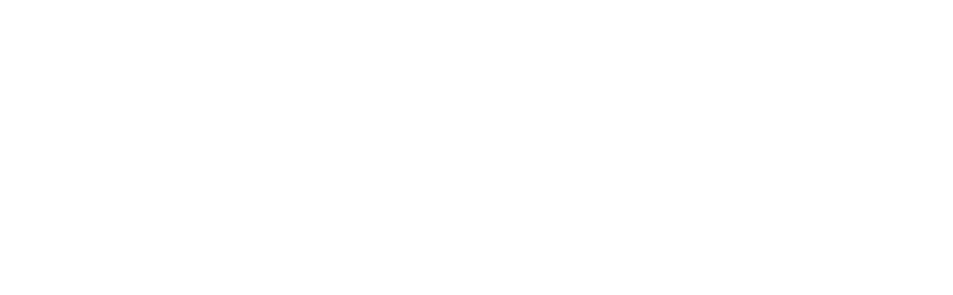

In [ ]:
fig = plt.figure()
cam = Camera(fig)
plt.xlim([-1,4])  
plt.axis('off')
bins = np.linspace(-1,4,7)    
centers = bins[:-1] + np.diff(bins) / 2.0
grid = np.linspace(-1,4,500)
mu_range = np.linspace(1,2,100)
data = np.random.normal(size=100)
truths = sts.norm(loc=mu_range.reshape(-1,1)).pdf(grid)
for i,mu in enumerate(mu_range):   
    plt.plot(grid,truths[i], color='C1')                             # plot true data distribution
    plt.hist(data+mu,bins=bins,density=True, color='C0', alpha=0.6) # histogram data
    plt.axvline(mu, color='slategray', linestyle=':', alpha=0.6)
    cam.snap()
animation = cam.animate()
# HTML(animation.to_html5_video()) # uncomment for animation!

## Making physics differentiable: <span style="color:blue">histograms</span>

An alternative: <span style="color:indigo">kernel density estimation</span>

$$\mathsf{kde}(x ; h, \mathsf{data}) = \mathsf{mean}_{i\,\in\,\mathsf{len(data)}}\left[K\left(\frac{x-\mathsf{data}[i]}{h}\right)\right]\times \frac{1}{h}$$

given some point $x$, kernel function $K$, and bandwith $h$ (smoothing parameter). In practice, *the choice of $h$ has significantly more impact on the shape of the kde than the kernel choice*.

Normally (ahem), we use the <span style="color:red">*standard normal distribution*</span> for $K$ 

$$\Rightarrow \mathsf{kde}(x ; h) = \mathsf{mean}_{i\,\in\,\mathsf{len(data)}}[\mathsf{Normal}(\mu_i = \mathsf{data}[i], \sigma_i = h )(x)]$$ 


**This is just an average of gaussians centered at each data point!** We control their widths *globally* using the bandwidth (one size fits all).

What happens when we vary the bandwidth?

<span style="color:teal">Example for a 1-D gaussian:</span>

<img src="assets/goodkde.gif" width="45%"/>

If we want to estimate counts in a binned interval, we can still do that!
- The kde is just a *mixture of gaussians*, and has a tractable pdf/cdf
- For a bin with edges $[a,b]$, one can just evaluate the density $f(a\leqslant x<b)$

<img src="assets/kde_bins.gif" width="45%"/>

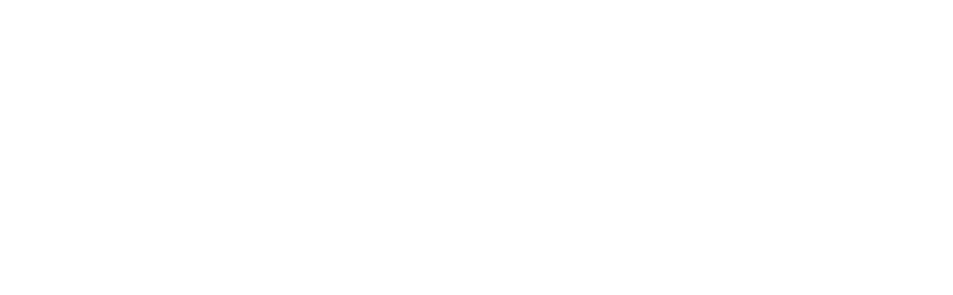

In [ ]:
bw = 0.6
fig = plt.figure()
cam = Camera(fig)
plt.xlim([-1,4])  
plt.axis('off')
for i,mu in enumerate(mu_range):   
    plt.plot(grid,truths[i], color='C1') 
    plt.plot(grid,kde(grid,data+mu,h = bw),color='C9',linestyle=':')
    plt.bar(centers,
            kde_hist(data+mu,bins=bins,bandwidth=bw,density=True), 
            color='C9', 
            width = 5/(len(bins) - 1),
            alpha=0.6) # histogram data
    plt.axvline(mu, color='slategray', linestyle=':', alpha=0.6)
    cam.snap()
animation = cam.animate()
# animation.save('ani.gif',writer='imagemagick')
# HTML(animation.to_html5_video()) # uncomment for animation!

### <span style="color:blue">Another 'soft' histogram:</span>

Could also use a **softmax**: $$ \mathsf{softmax}(\mathbf{x}; \tau)=\frac{e^{x_i / \tau}}{\sum_{i=0}^{\mathsf{len(\mathbf{x})}} e^{x_i / \tau}}$$

- $\tau$ is a softness hyperparameter, just like bandwidth!
- Softmax is a natural choice when working with a <span style="color:green">neural network </span> that maps events to an observable
    - $\mathbf{x}$ would be the output of $f$ for one event
    - Then get normalized counts, with len(bins) = len(output of $f$)
       

## Making physics differentiable: <span style="color:orange">likelihood function</span>

For the HistFactory-prescribed likelihood, [<span style="color:darkblue">**pyhf**</span>](https://github.com/scikit-hep/pyhf) has us covered$^*$!

$^*$not *everything* in pyhf is differentiable (yet)

<img src="assets/pyhf.png" width="50%"/>

Big thanks to the team :)

## Making physics differentiable: <span style="color:teal">profile likelihood ratio</span>

Things get trickier when we consider the profile likelihood ratio: 

$$\lambda(\mu)=\frac{L\left(\mu, \hat{\hat{\boldsymbol{\theta}}}\right)}{L\left(\hat{\mu}, \hat{\boldsymbol{\theta}}\right)}$$

Both $\hat{\hat{\boldsymbol{\theta}}}$ and $(\hat{\boldsymbol{\theta}},\hat{\boldsymbol{\mu}})$ are defined by $\mathsf{argmax}$ operators, which involve doing maximum likelihood fits.

*Fitting is not trivially differentiable!*

#### Why not?
- Normally involves a <span style="color:red">large number of iterations</span>, which would be unrolled one-by-one when tracing computations
 
    - We don't need all that information -- *we just want to know how the final fitted values change!*
- The number of iterations <span style="color:red">doesn't vary smoothly</span>

    
Solution? <span style="color:violet">**Fixed-point differentiation!**</span>



We can take advantage of the fact that $\mathsf{maximize}$ (or equivalently  $\mathsf{minimize}$) routines have a <span style="color:pink">**fixed point**</span>:
- $\mathsf{minimize}$($L$, $x_{\mathsf{init}}$) = $x_*$
- $\mathsf{minimize}$($L$, $x_*$) = $x_*$
- $\Rightarrow\mathsf{minimize}(L,x_*)-x_*=0~~,$ so $x_*$ is a fixed point of $\mathsf{minimize}$.

Now that we know a fixed point exists, we can calculate the gradient using the *converged iterations only!*

<img src="assets/fixed.png" width="50%"/>

(graphic from [this paper on adjoints of fixed-point iterations](https://hal.inria.fr/hal-01079185))

### Which gradient, exactly?

The pyhf likelihood (and its local maxima) is <span style="color:purple">*implicitly* a function of the signal and background yields.</span> We need this gradient in the wider context of optimizing wrt the profile likelihood ratio:

$$\frac{\partial \, \mathsf{profile~likelihood} }{\partial \, \mathsf{\varphi}} = \frac{\partial \, \mathsf{profile~likelihood} }{\partial (s,b)} \times \frac{\partial (s,b)}{\partial \, \mathsf{\mathsf{\varphi}}}$$

But then $\frac{\partial \, \mathsf{profile~likelihood} }{\partial (s,b)}$ involves $ \frac{\partial \, \mathsf{profile~likelihood} }{\partial \hat{\hat{\boldsymbol{\theta}}}} \times \frac{\partial \, \hat{\hat{\boldsymbol{\theta}}}}{\partial (s,b)}$ etc.



Think about the moving gaussian example: changing the parameter $\mu$ changed the shape of the histogram, but we don't write **histogram(data,$\mu$)**. Likewise, we don't write $\hat{\hat{\boldsymbol{\theta}}}(s,b)$, *but we can still find the gradient*!

## Putting it all together:
Recap:
- Using <span style="color:blue">'soft' histograms and cuts</span>, we can differentiate computations up to the stage of constructing an observable.
- Thanks to pyhf, we have <span style="color:orange">differentiable model building & likelihoods</span> that build off of this observable.
- Combined with <span style="color:pink">fixed-point differentiation</span>, we can extend this differentiability downstream to the <span style="color:teal">profile likelihood</span>.

**We now have the ingredients to differentiate a whole analysis!**

Now comes the fun part: lets *optimize* it :)

## Differentiable analysis in practice:

<img src="assets/neos-slide.png" width="70%"/>


because we don't need a neural net for differentiable analysis (though we do use one :D)

[Click me for Github! (and maybe leave a star... haha just kidding... unless?)](https://github.com/pyhf/neos)

neos is implemented in Python using [**jax**](https://github.com/google/jax) (think numpy, but differentiable)

<img src="assets/jax.png" width="20%"/>

- Lets you write numpythonic code, and get gradients for free!

We also make use of [**fax**](https://github.com/gehring/fax/), which contains a wrapper function that lets you take gradients of fixed-point loops using jax!

**Many thanks to both teams!**

In [ ]:
# Optional jax demo

<img src="assets/neoflow.png" width="70%"/>

## neos demo: softmax, 2 bins, 2 background blobs

<img src="assets/softmax_animation.gif" width="80%"/>

## neos demo: kde, 3 bins, 3 background blobs (up/down variations)

<img src="assets/pyhf_3.gif" width="80%"/>

## Next steps:

A high-level roadmap:

- Actually release a paper (the software is citable though: https://zenodo.org/record/3697981#.Xw8KmJNKhhE)
- Make pyhf *fully differentiable*
    - Would also be awesome to have awkward-array support autodiff (having this conversation on the side)
- More studies
- More differentiable tools


## Next steps:

Many of these goals are the target of gradHEP!

gradHEP is an effort to consolidate differentiable building blocks for analysis into a set of common tools, and apply them.

See the ['Differentiable computing' HSF activity](https://hepsoftwarefoundation.org/activities/differentiablecomputing.html) to find ways to get involved -- all are welcome at this very early stage! :)

<img src="assets/gradhep.png" width="20%"/>

Extra thanks:
- Pablo de Castro and Tommaso Dorigo for [INFERNO](https://arxiv.org/abs/1806.04743) (an inspiration for this work) and for discussions
- Folks in IRIS-HEP for their support & discussions
- Lukas for being a great supervisor
- The organisers of PyHEP! (you rock)

**and thanks to you for listening!! :)**

Twitters: [@phi_nate](https://twitter.com/phi_nate), [@lukasheinrich_](https://twitter.com/lukasheinrich_)

## Backup: which bandwidth?

Can get an optimal bandwidth wrt 'mean integrated square error' if you do adaptive kdes: see [this paper by Kyle Cranmer](https://arxiv.org/pdf/hep-ex/0011057.pdf)

Have also been doing some studies on bandwidth vs number of samples:


<img src="assets/kdestud.png" width="66%"/>


## Backup: softmax v kde?

A future study to be done! See [this issue on github](https://github.com/gradhep/center/issues/3)

It's debatable whether you get any additional expressivity from putting a kde on top of a neural network (and in practice, it seems like the softmax converges more stably), but:

<img src="assets/soft2.gif" width="76%"/>